# Baseline: Random Forest/Logistic Regression with FFs/MolDs

### Load data

In [1]:
'Set the file name of your data'
data_name = "CYP450.csv.gz"

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv("../../../data/" + data_name, compression='gzip')

Set up (adapt according to your data)

In [3]:
# keep desired columns
data = data[['smiles', 'label_2c9']]

# drop molecules with NaN activity
data = data.dropna(subset = ["label_2c9"])

# set SMILES
smi = data['smiles'].tolist()

# set Y
Y = pd.get_dummies(data['label_2c9']).values

# number of active and inactive molecules
print("Inactive (0):", Y[:,1].tolist().count(0))
print("Active (1):", Y[:,1].tolist().count(1))

Inactive (0): 7429
Active (1): 2621


### Compute FFs or MolDs

In [4]:
'Compute the Fmaps for FFs or MolDs. Choose only one of both.'
desc = "FFs"
# desc = "MolDs"

In [5]:
import sys
sys.path.append("../../../src")
import pickle
from pathlib import Path
from descriptors import MorganCalculator, MorganCalculator

path_mold = Path("../../../files/" + data_name + "/baselines/MolDs.pkl")
path_ff = Path("../../../files/" + data_name + "/baselines/FFs.pkl")

# compute MolDs
if desc == "MolDs":
    if path_mold.is_file():
        'If it exists, we load it.'
        with open(path_mold, "rb") as f:
            fps = pickle.load(f)
    else: 
        'Otherwise, we compute it and save it to disk.'
        md = MordredCalculator(smi)
        fps = md.calc_mordred()

        with open(path_mold, "wb+") as f:
            pickle.dump(fps, f, pickle.HIGHEST_PROTOCOL)
        
# or compute FFs
elif desc == "FFs":        
    if path_ff.is_file():
        'If it exists, we load it.'
        with open(path_ff, "rb") as f:
            fps = pickle.load(f)
    else: 
        'Otherwise, we compute it and save it to disk.'
        md = MorganCalculator(smi)
        fps = md.calc_morgan()

        with open(path_ff, "wb+") as f:
            pickle.dump(fps, f, pickle.HIGHEST_PROTOCOL)

### Split in train and test sets

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# set X and Y
X = fps.astype(float)
Y = np.array(Y[:,1]) 

# split train test
x_train, x_test, y_train, y_test = train_test_split(X,Y, stratify=Y, test_size=0.25, random_state=42)

### Preprocessing: Nan Filtering, Imputing & Scaling

In [7]:
from preprocessing import NanFilter

nanf = NanFilter()
nanf.fit(x_train)
x_train = nanf.transform(x_train)
x_test = nanf.transform(x_test)

Nan filtering, original columns 2048, final columns 2048


In [8]:
from preprocessing import Imputer

imp = Imputer()
imp.fit(x_train)
x_train = imp.transform(x_train)
x_test = imp.transform(x_test)

In [9]:
from preprocessing import Scaler

scal = Scaler()
scal.fit(x_train)
x_train = scal.transform(x_train)
x_test = scal.transform(x_test)

### Build and Fit Model

Hyperparameter tunning with FLAML. First, compute sample weight.

In [10]:
from utils import sample_weight

sw = sample_weight(y_train)

In [11]:
import flaml
from flaml import AutoML
import joblib

path = Path("../../../files/" + data_name + "/baselines/clf_sw.pkl")

if path.is_file():
    clf = joblib.load(path)

else: 
    TIME = 10
    clf_settings = {
        "time_budget":TIME * 60,
        "metric": 'roc_auc',
        "task": 'classification',
        "log_file_name": 'clf_log.log',
        "verbose" : 3,
        "sample_weight": sw,
        "estimator_list": ["lrl2", "rf"]
        }
    
    clf = AutoML()
    clf.fit(x_train, y_train, **clf_settings)
    joblib.dump(clf, path)

### Calibration curve

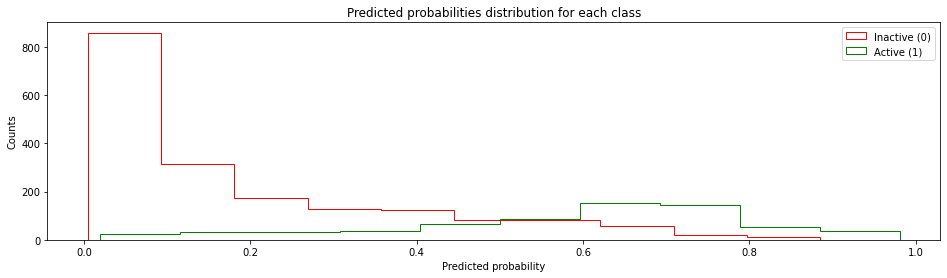

In [12]:
import matplotlib.pyplot as plt

# predict probabilities
df_pred = pd.DataFrame([y_test, clf.predict_proba(x_test)[:,1]]).T
df_pred.columns=['y_true', 'y_pred_prob']

# distributions for each class
dist0 = df_pred[df_pred['y_true'] == 0]['y_pred_prob'].tolist()
dist1 = df_pred[df_pred['y_true'] == 1]['y_pred_prob'].tolist()

# plot
plt.figure(figsize=(16, 4))
plt.title('Predicted probabilities distribution for each class')
plt.hist(dist0,histtype='step', label="Inactive (0)", color='r')  
plt.hist(dist1,histtype='step', label="Active (1)", color='g')
plt.xlabel('Predicted probability')
plt.ylabel('Counts')
plt.legend()
plt.show()

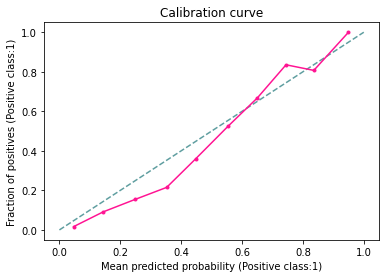

In [13]:
from sklearn.calibration import calibration_curve

# reliability diagram
fop, mpv = calibration_curve(df_pred['y_true'], df_pred['y_pred_prob'], n_bins=10)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', c='cadetblue')

# plot model reliability
plt.title('Calibration curve')
plt.plot(mpv, fop, marker='.', c='deeppink')
plt.xlabel('Mean predicted probability (Positive class:1)')
plt.ylabel('Fraction of positives (Positive class:1)')
plt.show()

### Evaluation metrics: ROC curve

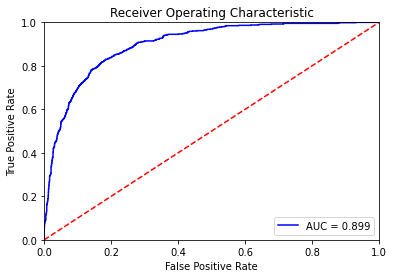

In [14]:
from sklearn import metrics

# ROC curve
fpr, tpr, threshold = metrics.roc_curve(df_pred['y_true'], df_pred['y_pred_prob'])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()